In [1]:
import pandas as pd
import geopandas as gpd
import csv
import requests
import zipfile
import os
import io
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
%matplotlib inline

/Users/vizzuality/anaconda3/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from processing.retriving_data import RetrieveBoundaries

## Table of Contents
- ### [1. Crop production - case study](#crop_production)
    - [1.1. Get crop specific information at country level from FAOSTAT](#faostat)
    - [1.2. Get 2000 cotton data from earthstat](#earthstat)
    - [1.3. Upscale the cotton harvest area layer](#upscale)
    - [1.4. Post-processing: rescaling extrapolated data](#postprocessing)
- ### [2. Scenario forecasting](#forecasting)
- ### [3. Final notes](#finalNotes)

In [6]:
processed_data = gpd.read_file('../../datasets/processed/user_data/located_lg_data_point_v2.shp')
processed_data.head()

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,710,India,Nakhon Nayok,NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (101.21471 14.20365)
1,Rubber,None,690,Thailand,"Bua Yai, Nakhon Ratchasima",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (102.42574 15.58717)
2,Rubber,None,660,Thailand,"Roi Et, Roi Et",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (103.65309 16.05625)
3,Rubber,None,650,India,"Nagercoil, Tamil Nadu",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (77.42905 8.18805)
4,Rubber,None,650,Thailand,"Phichit, Phichit",NaN,NaN,"Origin supplier facility (warehouse, silo, mil...",Medium,POINT (100.34303 16.44211)


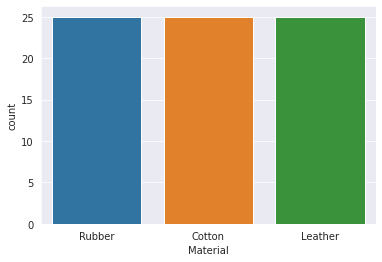

In [10]:

sns.set_style(style="darkgrid")
ax = sns.countplot(x="Material", data=processed_data)

In [11]:
processed_data.groupby('Material')['Volume'].sum()

Material
Cotton     53457
Leather    12048
Rubber     25196
Name: Volume, dtype: int64

<a id='crop_production'></a>
## 1. Crop production - case study

As a starting point we need crop especific data as can be yield or harvest area to compute the different metrics for each commodity. Currently exist detailed information at country level but this information is not homogenised for a global scale. However, there are some global scale crop-specifc dataset (e.g. Earthstat or Mapspam) but the spatial resolution and temporal resolution could be improved, for example using machine learning techniques. 

the current crop specific data that we have for a global scale includes:

- country data from FAOSTAT regarding harvest area, yield and production in a year basis
- Earthstat 2000 global harvest, production and year dataset for different commodities.

We can use the crop data from earthstat as initial dataset and extrapolate the inforation up to 2019 using the data from FAOSTAT.


<a id='faostat'></a>
### 1.1. Get crop specific information at country level from FAOSTAT

This data is country specific and has year information up to 2019.

In [38]:
## download FAOSTAT data forcotton in a year basis since 2000 up to 2019.
## http://www.fao.org/faostat/en/#data/QC

url = "http://fenixservices.fao.org/faostat/api/v1/en/data/QC?area=5000%3E&area_cs=FAO&element=2312&item=328&item_cs=FAO&year=2000%2C2001&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(data)
    
    
FAO_df = pd.DataFrame(my_list, columns=my_list[0])

In [39]:
FAO_df = FAO_df.drop(index=0)
FAO_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
1,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2000,2000,ha,50000,*,Unofficial figure
2,QC,Crops,2,Afghanistan,5312,Area harvested,328,Seed cotton,2001,2001,ha,50000,*,Unofficial figure
3,QC,Crops,3,Albania,5312,Area harvested,328,Seed cotton,2000,2000,ha,990,F,FAO estimate
4,QC,Crops,3,Albania,5312,Area harvested,328,Seed cotton,2001,2001,ha,840,F,FAO estimate
5,QC,Crops,4,Algeria,5312,Area harvested,328,Seed cotton,2000,2000,ha,141,Im,FAO data based on imputation methodology


In [9]:
# get fao data for indonesia
url = "http://fenixservices.fao.org/faostat/api/v1/en/data/QC?area=101&area_cs=FAO&element=2312&item=328&item_cs=FAO&year=2000%2C2001%2C2002%2C2003%2C2004%2C2005%2C2006%2C2007%2C2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017%2C2018%2C2019&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"
with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(data)
FAO_indonesia_df = pd.DataFrame(my_list, columns=my_list[0])

In [10]:
FAO_indonesia_df = FAO_indonesia_df.drop(index=0)
FAO_indonesia_df

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
1,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2000,2000,ha,11553,,Official data
2,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2001,2001,ha,10715,,Official data
3,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2002,2002,ha,9372,,Official data
4,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2003,2003,ha,6357,,Official data
5,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2004,2004,ha,7720,,Official data
6,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2005,2005,ha,5982,,Official data
7,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2006,2006,ha,6263,,Official data
8,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2007,2007,ha,13737,,Official data
9,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2008,2008,ha,11729,,Official data
10,QC,Crops,101,Indonesia,5312,Area harvested,328,Seed cotton,2009,2009,ha,12622,,Official data


<a id='earthstat'></a>
### 1.2. Get 2000 cotton data from earthstat

- Harvested Area: hectares: Crop-specific data representing the average number of hectares harvested per land-area of a gridcell during the 1997-2003 era

In [56]:
# download data from earthstat
# http://www.earthstat.org/harvested-area-yield-175-crops/
url = "https://s3.us-east-2.amazonaws.com/earthstatdata/HarvestedAreaYield175Crops_Indvidual_Geotiff/cotton_HarvAreaYield_Geotiff.zip"

local_path = '../raw_data/cotton_earthstat'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    print("Data extracted!")

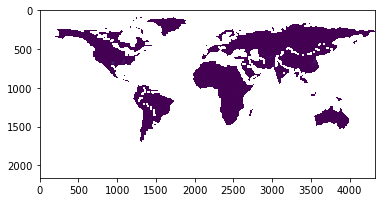

In [78]:
# Use rasterio to import the reprojected data as img
out_path = '../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif'
with rio.open(out_path) as src:
    arr = src.read(out_shape=(src.height, src.width))



plt.imshow(arr[0])
plt.show()

In [84]:
# get country data from
url = "https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IDN_shp.zip"
local_path = '../raw_data/gadm_indonesia'
if not os.path.isdir(local_path):
    os.mkdir(local_path)

    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print("Done")
    z.extractall(path=local_path) # extract to folder
    print("Data extracted!")

Done
Data extracted!


In [91]:
gadm_ind = gpd.read_file('../raw_data/gadm_indonesia/gadm36_IDN_0.shp')
gadm_ind.head()

,fid,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,1.0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((122.87141 -10.96885, 122.87312..."


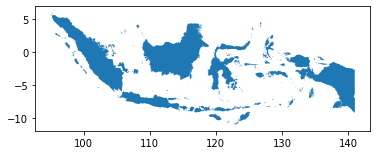

In [93]:
gadm_ind.plot()

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


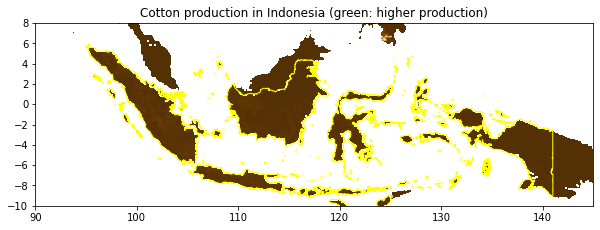

In [99]:
with rio.open('../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((-10,8))
    ax.set_xlim((90,145))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    gadm_ind.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton production in Indonesia (green: higher production)')

In [108]:
feature = RetrieveBoundaries(query='India')

Params:OrderedDict([('format', 'json'), ('limit', 1), ('dedupe', 0), ('polygon_geojson', 1), ('q', 'India')])
Preparing url: https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=India


In [110]:

gdf = gpd.GeoDataFrame.from_features(feature.feature_json, crs='epsg:4326')
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((68.11138 23.60145, 68.11501 23...",India,35.523233,6.232527,97.395561,68.111379


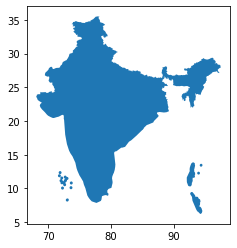

In [111]:
gdf.plot()

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


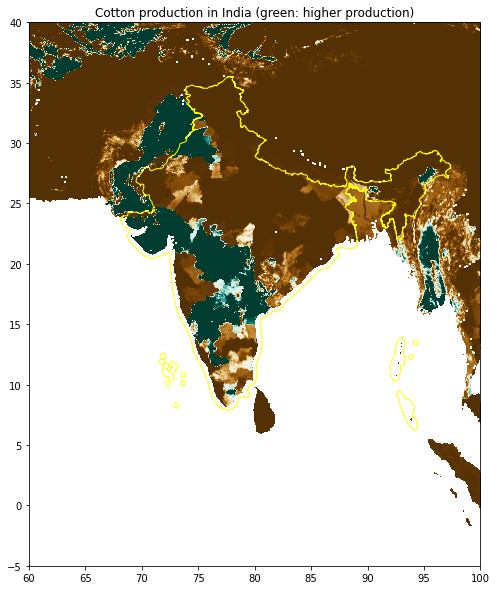

In [124]:
with rio.open('../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-5,40))
    ax.set_xlim((60,100))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    gdf.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton production in India (green: higher production)')

<a id='upscale'></a>
### 1.3. Upscale the cotton harvest area layer

Extrapolate up to 2019 the earthstat data by using an upscaling factor derived from the FAO data.


Upscaling_factor = harvest_area_start_year / harvest_area_end_year


#### 3.1  Calculation of the upscaling factor

In [122]:
## get upscaling factor for indonesia
upscaling_factor = float(FAO_indonesia_df.iloc[1].Value)/float(FAO_indonesia_df.iloc[0].Value)
print(f'The upscaling factor is: {upscaling_factor}')

The upscaling factor is: 0.9274647277763352


In [132]:
## ad upscaling factor to admin area
gadm_ind['scl_factor']=upscaling_factor
gadm_ind

,fid,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,scl_factor
0,1.0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((122.87141 -10.96885, 122.87312...",0.927465


#### 3.2  Rasterize the admin area with the upscaling factor

In [130]:
#generate a raster mask with value 1 for the harvest area tiff
with rio.open('../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif') as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0833333333333286, 0.0, -180.0,
       0.0, -0.0833333333333286, 89.99999999998977), 'blockxsize': 432, 'blockysize': 224, 'tiled': True, 'compress': 'packbits', 'interleave': 'band'}


In [135]:
!gdal_rasterize -l gadm36_IDN_0 -a scl_factor -ts 4320.0 2160.0 -a_nodata 1.0 -te -180.0 -90.0 180.0 90.0 -ot Float32 -of GTiff ../raw_data/gadm_indonesia/gadm36_IDN_0.shp ../raw_data/harvest_area_scale_factor_mask_v2.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [136]:
#check the mask
with rio.open('../raw_data/harvest_area_scale_factor_mask_v2.tif') as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 1.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'tiled': False, 'interleave': 'band'}


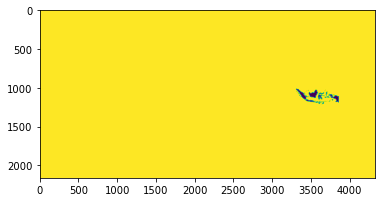

In [137]:
# Use rasterio to import the reprojected data as img
out_path = '../raw_data/harvest_area_scale_factor_mask_v2.tif'
with rio.open(out_path) as src:
    arr = src.read(out_shape=(src.height, src.width))



plt.imshow(arr[0])
plt.show()

#### 3.2  Generate the upscaling layer by multiplaying the two rasters

In [138]:
!gdal_calc.py -A ../raw_data/harvest_area_scale_factor_mask_v2.tif -B ../raw_data/cotton_earthstat/cotton_HarvAreaYield_Geotiff/cotton_HarvestedAreaHectares.tif --outfile=../Processed_data/cotton_2001_harvest_area.tif --calc="A*B"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 1

 77.. 77.. 77.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 79.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 81.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 82.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 83.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 85.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 86.. 87.. 87..

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:146: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  collection = PatchCollection([PolygonPatch(poly) for poly in geoms], **kwargs)


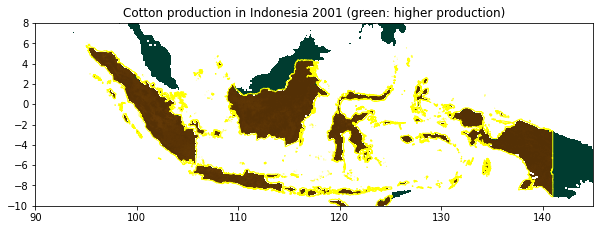

In [141]:


with rio.open('../Processed_data/cotton_2001_harvest_area.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[10,5])
    ax.set_ylim((-10,8))
    ax.set_xlim((90,145))
    rio.plot.show(dat, vmax=100, cmap='BrBG', ax=ax, transform=src.transform)
    gadm_ind.plot(ax=ax, color='', edgecolor='yellow')
    ax.set_title('Cotton production in Indonesia 2001 (green: higher production)')

<a id='postprocessing'></a>
### 1.4. Post-processing: rescaling extrapolated data

Identifying discrepancies for example where the actual harvest area is greater than the area of the grid cell.

<a id='forecasting'></a>
### 2. Scenario forecasting

Another thing we should consider for incorporating the scenario forecasting in the land griffon platform is how we are going to project the impacts factors. To do so we can identify two approaches:

  1. Consider the baseline commodity information retrieved from Earthstat or Mapspam as base information that is going to be maintained as constant in the future. The change in impacts over time would depend mainly from the growth rate value assigned by the user.

  2. Project the crop data (yield and harvest area) using the information retrieved from FAOSTAT considering a linear growth from 2019 upwards.

In this notebook we will try to cover approach 2:

#### Approach two - commodity information projected using FAOSTAT

A more sophisticated approach could be to assume that harvest area and yield will change over time and therefore this data can be projected in our scenario forecasting. To do so we can use the historical data from FAOSTAT to obtain a projection factor.

To obtain this projection factor we can download the FAOSTAT from 2000 to 2019 and calculate the annual change (scale factor). Once we have computed the annual change over this selected period of time we can compute the average change over this time and use that as a forecasting factor. 

This forecasting value would be applied to the yield and harvest area information for each country considering a linear implementation over time from 2019 and forward.

More information can be found in the [Crop projections - working with projections and scenario forecasting document](https://docs.google.com/document/d/1YF7yCFPVdWuZrSxHMsyUeWqaJzMIrsI4C5MnmbS5n0o/edit#).

In [7]:
#download data from fao
#download country specific yield for cotton from 2000 to 2019

url = "http://fenixservices.fao.org/faostat/api/v1/en/data/QC?area=5000%3E&area_cs=FAO&element=2413&item=328&item_cs=FAO&year=2000%2C2001%2C2002%2C2003%2C2004%2C2005%2C2006%2C2007%2C2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017%2C2018%2C2019&show_codes=true&show_unit=true&show_flags=true&null_values=false&output_type=csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    data = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(data)
FAO_df_2000_2019 = pd.DataFrame(my_list, columns=my_list[0])

In [9]:
FAO_df_2000_2019 = FAO_df_2000_2019.drop(index=0)
FAO_df_2000_2019.head()

,Domain Code,Domain,Area Code (FAO),Area,Element Code,Element,Item Code (FAO),Item,Year Code,Year,Unit,Value,Flag,Flag Description
1,QC,Crops,2,Afghanistan,5419,Yield,328,Seed cotton,2000,2000,hg/ha,11400,Fc,Calculated data
2,QC,Crops,2,Afghanistan,5419,Yield,328,Seed cotton,2001,2001,hg/ha,11400,Fc,Calculated data
3,QC,Crops,2,Afghanistan,5419,Yield,328,Seed cotton,2002,2002,hg/ha,11400,Fc,Calculated data
4,QC,Crops,2,Afghanistan,5419,Yield,328,Seed cotton,2003,2003,hg/ha,11000,Fc,Calculated data
5,QC,Crops,2,Afghanistan,5419,Yield,328,Seed cotton,2004,2004,hg/ha,10980,Fc,Calculated data


In [72]:
#clean dataframe to get just one year

unique_countries = list(FAO_df_2000_2019['Area'].unique())
unique_years = list(FAO_df_2000_2019['Year'].unique())
list_values = {}
for country in unique_countries:
    list_values[country] = {}
    for year in unique_years:
        try:
            value = float(FAO_df_2000_2019[(FAO_df_2000_2019['Area']==country) & (FAO_df_2000_2019['Year']==year)].iloc[0]['Value'])
        except:
            value = 0   
        list_values[country][year] = value
           

In [73]:
fao_df_pf = pd.DataFrame(list_values).transpose()
fao_df_pf.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Afghanistan,11400.0,11400.0,11400.0,11000.0,10980.0,11000.0,10016.0,10015.0,10000.0,12992.0,10000.0,10000.0,11000.0,11618.0,12237.0,11984.0,11545.0,11547.0,14546.0,14810.0
Albania,9495.0,9524.0,9524.0,9500.0,9528.0,9537.0,9259.0,9474.0,9459.0,9919.0,10014.0,10095.0,10189.0,11081.0,11081.0,11081.0,11081.0,11081.0,11081.0,11086.0
Algeria,4468.0,4336.0,4247.0,4106.0,4000.0,3902.0,3868.0,3710.0,3636.0,3497.0,3100.0,3318.0,3000.0,3000.0,3077.0,3077.0,3077.0,3077.0,3077.0,2909.0
Angola,9900.0,13500.0,14860.0,15740.0,16515.0,17290.0,18200.0,18000.0,17500.0,18000.0,17000.0,18000.0,18333.0,18333.0,18333.0,18333.0,18333.0,18333.0,18333.0,18384.0
Antigua and Barbuda,1333.0,1417.0,1385.0,1357.0,1357.0,1357.0,1357.0,1357.0,1357.0,1357.0,1357.0,1357.0,1667.0,1750.0,1750.0,1750.0,1750.0,1750.0,1750.0,1753.0


In [80]:
#calculate percentage change 
fao_df_pf = fao_df_pf.pct_change(axis='columns')
fao_df_pf.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Afghanistan,NaN,0.000000,0.000000,-0.035088,-0.001818,0.001821,-0.089455,-0.000100,-0.001498,0.299200,-0.230296,0.000000,0.100000,0.056182,0.053279,-0.020675,-0.036632,0.000173,0.259721,0.018149
Albania,NaN,0.003054,0.000000,-0.002520,0.002947,0.000945,-0.029150,0.023221,-0.001583,0.048631,0.009578,0.008089,0.009312,0.087545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000451
Algeria,NaN,-0.029543,-0.020526,-0.033200,-0.025816,-0.024500,-0.008713,-0.040848,-0.019946,-0.038229,-0.113526,0.070323,-0.095841,0.000000,0.025667,0.000000,0.000000,0.000000,0.000000,-0.054599
Angola,NaN,0.363636,0.100741,0.059219,0.049238,0.046927,0.052632,-0.010989,-0.027778,0.028571,-0.055556,0.058824,0.018500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002782
Antigua and Barbuda,NaN,0.063016,-0.022583,-0.020217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228445,0.049790,0.000000,0.000000,0.000000,0.000000,0.000000,0.001714


In [82]:
fao_df_pf['mean'] = fao_df_pf.mean(axis=1)
fao_df_pf['median'] = fao_df_pf.median(axis=1)
fao_df_pf.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,mean,median
Afghanistan,NaN,0.000000,0.000000,-0.035088,-0.001818,0.001821,-0.089455,-0.000100,-0.001498,0.299200,...,0.100000,0.056182,0.053279,-0.020675,-0.036632,0.000173,0.259721,0.018149,0.019630,0.000000
Albania,NaN,0.003054,0.000000,-0.002520,0.002947,0.000945,-0.029150,0.023221,-0.001583,0.048631,...,0.009312,0.087545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000451,0.008448,0.000698
Algeria,NaN,-0.029543,-0.020526,-0.033200,-0.025816,-0.024500,-0.008713,-0.040848,-0.019946,-0.038229,...,-0.095841,0.000000,0.025667,0.000000,0.000000,0.000000,0.000000,-0.054599,-0.021542,-0.021034
Angola,NaN,0.363636,0.100741,0.059219,0.049238,0.046927,0.052632,-0.010989,-0.027778,0.028571,...,0.018500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002782,0.036145,0.010641
Antigua and Barbuda,NaN,0.063016,-0.022583,-0.020217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.228445,0.049790,0.000000,0.000000,0.000000,0.000000,0.000000,0.001714,0.015798,0.000000


In [89]:
fao_df_pf_transpose = fao_df_pf.transpose()

In [84]:
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [92]:
fao_df_pf.plot_bokeh(kind='bar') 

Figure(id='12797', ...)

In [93]:
fao_df_pf[['mean','median']].plot_bokeh(kind='bar') 

Figure(id='13500', ...)

In [91]:
fao_df_pf_transpose.plot_bokeh(kind='line')

Figure(id='2316', ...)

In [107]:
fao_df_pf_transpose.loc[['mean', 'median']].plot_bokeh(kind='bar')

Figure(id='27417', ...)

In [108]:
fao_df_pf_transpose.loc[['mean', 'median']][['Afghanistan', 'Albania', 'Algeria', 'Angola']].plot_bokeh(kind='bar')

Figure(id='29458', ...)

In [105]:
fao_df_pf.transpose()[['Afghanistan', 'Albania', 'Algeria', 'Angola']].plot_bokeh(kind='line')

Figure(id='26700', ...)

<a id='finalNotes'></a>
### 3. Final notes

The mean obtained for each country can be used for computing the pdifferent projections.